In [128]:
import pyodbc
import hashlib
import gc

import numpy as np
import pandas as pd
import os
import sys
import time 
import datetime
import copy

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

import sklearn.metrics as metrics

from itertools import islice

In [129]:
conn = pyodbc.connect("DSN=CarmelODBCDSII", autocommit = True)
curs = conn.cursor()

In [130]:
sql_str = """select * from P_TRAFFIC_T.HC_US_USER_FM_2001_V2_1000_log"""  
df = pd.read_sql(sql_str, conn)

In [131]:
#df['app_flag']= np.where(df['USER_TYPE']== 'Non-App' , 0,1)

In [132]:
df[pd.isnull(df).any(axis=1)].shape
df =df.dropna()

In [133]:
df.shape

(1304918, 53)

In [134]:
df.head()

,PRIMARY_USER_ID,USER_CNTRY_ID,TXN_DT,USER_GROUP,SEGM,USR_CREATED_DT,OPT_IN_EMAIL_IND,BYNG_TRANS_CNT_365D,GMB_USD_AMT_365D,ITEM_PRCHSD_CNT_365D,...,BID_CNT_07D,OFFER_CNT_07D,ADD_TO_CART_CNT_07D,WATCH_CNT_07D,CNT_TOTAL_ITEMS_07D,CNT_VERTICALS_07D,CNT_META_CATEG_07D,CNT_CNDTN_ROLLUP_07D,app_flag,POST_GMB_USD_AMT_365D
0,1.070958e+09,1.0,2020-06-19,0,02.MEDIUM,2011-07-26,N,5.062595,7.031735,5.111988,...,2.484907,2.944439,2.484907,2.708050,3.912023,1.098612,1.098612,1.386294,0,587.498955
1,1.077840e+09,1.0,2020-06-09,0,02.MEDIUM,2011-09-10,Y,2.708050,6.577472,2.708050,...,1.609438,0.000000,1.609438,1.098612,2.564949,0.693147,0.693147,1.386294,0,423.480000
2,3.302516e+08,1.0,2020-05-25,0,02.MEDIUM,2006-04-23,Y,2.944439,6.389267,2.944439,...,1.386294,0.000000,1.098612,1.609438,2.639057,0.693147,1.098612,1.386294,0,2913.790000
3,1.957244e+09,1.0,2020-06-09,0,02.MEDIUM,2019-04-19,Y,1.791759,5.801605,1.791759,...,0.693147,0.000000,0.693147,0.000000,1.098612,0.693147,0.693147,0.693147,0,332.830000
4,1.204702e+09,1.0,2020-04-07,0,04.NORB,2013-11-21,Y,1.098612,5.930759,2.197225,...,1.098612,0.000000,1.098612,0.000000,1.945910,1.098612,1.098612,1.098612,0,3.750000


In [135]:
df[["PRIMARY_USER_ID","app_flag"]].groupby('app_flag').count()

,PRIMARY_USER_ID
app_flag,
0,1291998
1,12920


In [9]:
column_names =[
"PRIMARY_USER_ID"
,"USER_CNTRY_ID"
,"TXN_DT"
,"USER_GROUP"
,"SEGM"
,"USR_CREATED_DT"
,"OPT_IN_EMAIL_IND"
,"BYNG_TRANS_CNT_365D"
,"GMB_USD_AMT_365D"
,"ITEM_PRCHSD_CNT_365D"
,"BID_CNT_365D"
,"OFFER_CNT_365D"
,"ADD_TO_CART_CNT_365D"
,"WATCH_CNT_365D"
,"CNT_TOTAL_ITEMS_365D"
,"CNT_VERTICALS_365D"
,"CNT_META_CATEG_365D"
,"CNT_CNDTN_ROLLUP_365D"
,"BYNG_TRANS_CNT_90D"
,"GMB_USD_AMT_90D"
,"ITEM_PRCHSD_CNT_90D"
,"BID_CNT_90D"
,"OFFER_CNT_90D"
,"ADD_TO_CART_CNT_90D"
,"WATCH_CNT_90D"
,"CNT_TOTAL_ITEMS_90D"
,"CNT_VERTICALS_90D"
,"CNT_META_CATEG_90D"
,"CNT_CNDTN_ROLLUP_90D"
,"BYNG_TRANS_CNT_30D"
,"GMB_USD_AMT_30D"
,"ITEM_PRCHSD_CNT_30D"
,"BID_CNT_30D"
,"OFFER_CNT_30D"
,"ADD_TO_CART_CNT_30D"
,"WATCH_CNT_30D"
,"CNT_TOTAL_ITEMS_30D"
,"CNT_VERTICALS_30D"
,"CNT_META_CATEG_30D"
,"CNT_CNDTN_ROLLUP_30D"
,"BYNG_TRANS_CNT_07D"
,"GMB_USD_AMT_07D"
,"ITEM_PRCHSD_CNT_07D"
,"BID_CNT_07D"
,"OFFER_CNT_07D"
,"ADD_TO_CART_CNT_07D"
,"WATCH_CNT_07D"
,"CNT_TOTAL_ITEMS_07D"
,"CNT_VERTICALS_07D"
,"CNT_META_CATEG_07D"
,"CNT_CNDTN_ROLLUP_07D"
,"app_flag"
,"POST_GMB_USD_AMT_365D"
 ]

In [10]:
df[column_names].head(5)

,PRIMARY_USER_ID,USER_CNTRY_ID,TXN_DT,USER_GROUP,SEGM,USR_CREATED_DT,OPT_IN_EMAIL_IND,BYNG_TRANS_CNT_365D,GMB_USD_AMT_365D,ITEM_PRCHSD_CNT_365D,...,BID_CNT_07D,OFFER_CNT_07D,ADD_TO_CART_CNT_07D,WATCH_CNT_07D,CNT_TOTAL_ITEMS_07D,CNT_VERTICALS_07D,CNT_META_CATEG_07D,CNT_CNDTN_ROLLUP_07D,app_flag,POST_GMB_USD_AMT_365D
0,1.227146e+09,77.0,2020-06-07,0,02.MEDIUM,2014-02-23,Y,1.609438,3.518260,1.609438,...,1.098612,0.000000,0.000000,0.000000,0.693147,0.693147,0.693147,0.693147,0,12.233600
1,1.637541e+09,77.0,2020-04-16,0,02.MEDIUM,2017-06-18,N,3.258097,5.975367,3.258097,...,0.693147,0.000000,0.693147,0.000000,1.386294,0.693147,0.693147,1.098612,0,167.435182
2,7.955908e+08,77.0,2020-04-28,0,01.HIGH,2008-07-02,Y,5.187386,9.886458,5.273000,...,4.941642,1.098612,3.295837,5.624018,6.093570,1.098612,1.386294,1.609438,0,7330.680546
3,2.168868e+08,77.0,2020-04-12,0,02.MEDIUM,2005-07-17,Y,2.302585,6.895010,2.484907,...,1.098612,0.000000,1.098612,2.890372,3.218876,1.098612,1.609438,1.098612,0,185.057885
4,6.235427e+07,77.0,2020-04-01,0,02.MEDIUM,2002-08-19,Y,3.218876,6.968595,3.784190,...,1.945910,0.000000,1.386294,0.000000,2.302585,1.386294,1.609438,1.386294,0,156.861119


In [11]:
data=df[column_names]

In [12]:
data.shape

(388241, 53)

In [13]:
data.head(2)

,PRIMARY_USER_ID,USER_CNTRY_ID,TXN_DT,USER_GROUP,SEGM,USR_CREATED_DT,OPT_IN_EMAIL_IND,BYNG_TRANS_CNT_365D,GMB_USD_AMT_365D,ITEM_PRCHSD_CNT_365D,...,BID_CNT_07D,OFFER_CNT_07D,ADD_TO_CART_CNT_07D,WATCH_CNT_07D,CNT_TOTAL_ITEMS_07D,CNT_VERTICALS_07D,CNT_META_CATEG_07D,CNT_CNDTN_ROLLUP_07D,app_flag,POST_GMB_USD_AMT_365D
0,1.227146e+09,77.0,2020-06-07,0,02.MEDIUM,2014-02-23,Y,1.609438,3.518260,1.609438,...,1.098612,0.0,0.000000,0.0,0.693147,0.693147,0.693147,0.693147,0,12.233600
1,1.637541e+09,77.0,2020-04-16,0,02.MEDIUM,2017-06-18,N,3.258097,5.975367,3.258097,...,0.693147,0.0,0.693147,0.0,1.386294,0.693147,0.693147,1.098612,0,167.435182


## Data Exploration

/home/yliu40/anaconda32/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


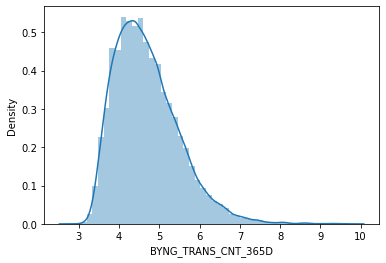

In [14]:
high = data.loc[data['SEGM']=='01.HIGH']
medium = data.loc[data['SEGM']=='02.MEDIUM']
low = data.loc[data['SEGM']=='03.LOW']
norb = data.loc[data['SEGM']=='04.NORB']

sns.distplot(high.BYNG_TRANS_CNT_365D)


/home/yliu40/anaconda32/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


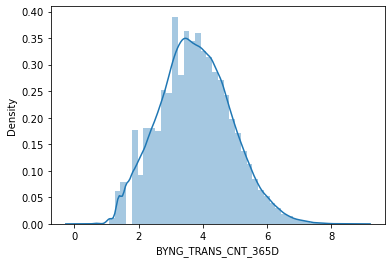

In [15]:
sns.distplot(medium.BYNG_TRANS_CNT_365D)

/home/yliu40/anaconda32/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


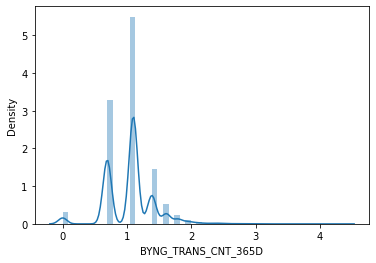

In [16]:
sns.distplot(low.BYNG_TRANS_CNT_365D)

/home/yliu40/anaconda32/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


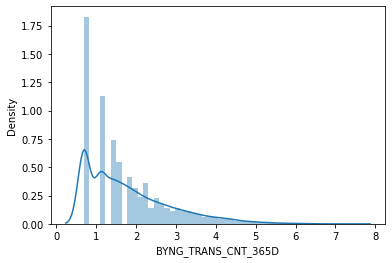

In [17]:
sns.distplot(norb.BYNG_TRANS_CNT_365D)

In [18]:
process_column_names =[
"BYNG_TRANS_CNT_365D"
,"GMB_USD_AMT_365D"
,"ITEM_PRCHSD_CNT_365D"
,"BID_CNT_365D"
,"OFFER_CNT_365D"
,"ADD_TO_CART_CNT_365D"
,"WATCH_CNT_365D"
,"CNT_TOTAL_ITEMS_365D"
,"CNT_VERTICALS_365D"
,"CNT_META_CATEG_365D"
,"CNT_CNDTN_ROLLUP_365D"
,"BYNG_TRANS_CNT_90D"
,"GMB_USD_AMT_90D"
,"ITEM_PRCHSD_CNT_90D"
,"BID_CNT_90D"
,"OFFER_CNT_90D"
,"ADD_TO_CART_CNT_90D"
,"WATCH_CNT_90D"
,"CNT_TOTAL_ITEMS_90D"
,"CNT_VERTICALS_90D"
,"CNT_META_CATEG_90D"
,"CNT_CNDTN_ROLLUP_90D"
,"BYNG_TRANS_CNT_30D"
,"GMB_USD_AMT_30D"
,"ITEM_PRCHSD_CNT_30D"
,"BID_CNT_30D"
,"OFFER_CNT_30D"
,"ADD_TO_CART_CNT_30D"
,"WATCH_CNT_30D"
,"CNT_TOTAL_ITEMS_30D"
,"CNT_VERTICALS_30D"
,"CNT_META_CATEG_30D"
,"CNT_CNDTN_ROLLUP_30D"
,"BYNG_TRANS_CNT_07D"
,"GMB_USD_AMT_07D"
,"ITEM_PRCHSD_CNT_07D"
,"BID_CNT_07D"
,"OFFER_CNT_07D"
,"ADD_TO_CART_CNT_07D"
,"WATCH_CNT_07D"
,"CNT_TOTAL_ITEMS_07D"
,"CNT_VERTICALS_07D"
,"CNT_META_CATEG_07D"
,"CNT_CNDTN_ROLLUP_07D"
 ]

In [19]:
for i in process_column_names:
    print(high[i].describe())

count    73834.000000
mean         4.686703
std          0.798124
min          2.772589
25%          4.094345
50%          4.564348
75%          5.147494
max          9.822549
Name: BYNG_TRANS_CNT_365D, dtype: float64
count    73834.000000
mean         8.557663
std          0.760964
min          6.135689
25%          7.996341
50%          8.462686
75%          9.009182
max         14.072689
Name: GMB_USD_AMT_365D, dtype: float64
count    73834.000000
mean         4.971026
std          0.843546
min          2.772589
25%          4.330733
50%          4.875197
75%          5.493061
max          9.822549
Name: ITEM_PRCHSD_CNT_365D, dtype: float64
count    73834.000000
mean         5.022754
std          0.981807
min          3.178054
25%          4.304065
50%          4.852030
75%          5.521461
max         11.000932
Name: BID_CNT_365D, dtype: float64
count    73834.000000
mean         2.085309
std          1.661578
min          0.000000
25%          0.693147
50%          2.079442
75%  

In [20]:
for i in process_column_names:
    print(medium[i].describe())

count    292250.000000
mean          3.759554
std           1.120335
min           0.000000
25%           2.995732
50%           3.737670
75%           4.510860
max           8.944028
Name: BYNG_TRANS_CNT_365D, dtype: float64
count    292250.000000
mean          6.795012
std           1.060424
min           0.000000
25%           6.156648
50%           6.900784
75%           7.525151
max          11.965025
Name: GMB_USD_AMT_365D, dtype: float64
count    292250.000000
mean          3.914038
std           1.127104
min           0.000000
25%           3.135494
50%           3.912023
75%           4.682131
max           8.944028
Name: ITEM_PRCHSD_CNT_365D, dtype: float64
count    292250.000000
mean          4.151717
std           1.316949
min           0.693147
25%           3.218876
50%           4.043051
75%           4.962845
max          11.194179
Name: BID_CNT_365D, dtype: float64
count    292250.000000
mean          1.366504
std           1.463067
min           0.000000
25%          

In [21]:
for i in process_column_names:
    print(low[i].describe())

count    5498.000000
mean        1.053260
std         0.372554
min         0.000000
25%         0.693147
50%         1.098612
75%         1.098612
max         4.330733
Name: BYNG_TRANS_CNT_365D, dtype: float64
count    5498.000000
mean        3.863801
std         1.335332
min         0.000000
25%         3.101902
50%         3.883410
75%         4.713591
max         9.258434
Name: GMB_USD_AMT_365D, dtype: float64
count    5498.000000
mean        1.140889
std         0.481403
min         0.000000
25%         0.693147
50%         1.098612
75%         1.386294
max         4.867534
Name: ITEM_PRCHSD_CNT_365D, dtype: float64
count    5498.000000
mean        1.459857
std         0.706394
min         0.000000
25%         1.098612
50%         1.098612
75%         1.609438
max         6.569481
Name: BID_CNT_365D, dtype: float64
count    5498.000000
mean        0.214201
std         0.527421
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.174387
N

In [22]:
for i in process_column_names:
    print(norb[i].describe())

count    16659.000000
mean         1.780965
std          1.065626
min          0.693147
25%          1.098612
50%          1.609438
75%          2.397895
max          7.412764
Name: BYNG_TRANS_CNT_365D, dtype: float64
count    16659.000000
mean         4.714354
std          1.588880
min          0.528956
25%          3.583006
50%          4.658369
75%          5.774496
max         12.151529
Name: GMB_USD_AMT_365D, dtype: float64
count    16659.000000
mean         1.897293
std          1.116944
min          0.693147
25%          1.098612
50%          1.609438
75%          2.564949
max          7.417580
Name: ITEM_PRCHSD_CNT_365D, dtype: float64
count    16659.000000
mean         2.140576
std          1.358354
min          0.000000
25%          1.098612
50%          1.791759
75%          2.890372
max          8.444622
Name: BID_CNT_365D, dtype: float64
count    16659.000000
mean         0.406743
std          0.937867
min          0.000000
25%          0.000000
50%          0.000000
75%  

In [23]:
print(high.shape)
print(medium.shape)
print(low.shape)
print(norb.shape)
print(data.shape)

(73834, 53)
(292250, 53)
(5498, 53)
(16659, 53)
(388241, 53)


In [24]:
app = data.loc[data['app_flag']==1]

In [25]:
app.shape

(3844, 53)

In [26]:
non_app = data.loc[data['app_flag']==0]

In [27]:
non_app.shape

(384397, 53)

In [28]:
sample_size=app.groupby(['SEGM','TXN_DT'], as_index=True)['PRIMARY_USER_ID'].nunique()
sample_size

SEGM     TXN_DT    
01.HIGH  2020-04-03     2
         2020-04-05     3
         2020-04-06     1
         2020-04-07     2
         2020-04-09     2
                       ..
04.NORB  2020-06-26    16
         2020-06-27    13
         2020-06-28    13
         2020-06-29     9
         2020-06-30     9
Name: PRIMARY_USER_ID, Length: 319, dtype: int64

In [29]:
sample_size=pd.DataFrame(sample_size)
sample_size

PRIMARY_USER_ID
SEGM    TXN_DT                     
01.HIGH 2020-04-03                2
        2020-04-05                3
        2020-04-06                1
        2020-04-07                2
        2020-04-09                2
...                             ...
04.NORB 2020-06-26               16
        2020-06-27               13
        2020-06-28               13
        2020-06-29                9
        2020-06-30                9

[319 rows x 1 columns]

In [30]:
sample_size.reset_index(inplace=True)
sample_size

,SEGM,TXN_DT,PRIMARY_USER_ID
0,01.HIGH,2020-04-03,2
1,01.HIGH,2020-04-05,3
2,01.HIGH,2020-04-06,1
3,01.HIGH,2020-04-07,2
4,01.HIGH,2020-04-09,2
...,...,...,...
314,04.NORB,2020-06-26,16
315,04.NORB,2020-06-27,13
316,04.NORB,2020-06-28,13
317,04.NORB,2020-06-29,9


In [31]:
sample_size.rename(columns = {'PRIMARY_USER_ID':'User_Cnt'}, inplace = True)
sample_size

,SEGM,TXN_DT,User_Cnt
0,01.HIGH,2020-04-03,2
1,01.HIGH,2020-04-05,3
2,01.HIGH,2020-04-06,1
3,01.HIGH,2020-04-07,2
4,01.HIGH,2020-04-09,2
...,...,...,...
314,04.NORB,2020-06-26,16
315,04.NORB,2020-06-27,13
316,04.NORB,2020-06-28,13
317,04.NORB,2020-06-29,9


In [32]:
sample_size['User_Cnt_F'] = sample_size['User_Cnt']*2

In [33]:
sample_size.head()

,SEGM,TXN_DT,User_Cnt,User_Cnt_F
0,01.HIGH,2020-04-03,2,4
1,01.HIGH,2020-04-05,3,6
2,01.HIGH,2020-04-06,1,2
3,01.HIGH,2020-04-07,2,4
4,01.HIGH,2020-04-09,2,4


In [34]:
sample_size.User_Cnt_F.sum()

7688

In [35]:
SEGM_match= sample_size.drop_duplicates('SEGM')['SEGM']
SEGM_match

0        01.HIGH
63     02.MEDIUM
154       03.LOW
228      04.NORB
Name: SEGM, dtype: object

In [36]:
SEGM_match=SEGM_match.tolist()
SEGM_match

['01.HIGH', '02.MEDIUM', '03.LOW', '04.NORB']

In [37]:
np.random.seed(seed=1000)

In [38]:
non_app_final= pd.DataFrame()

for i in SEGM_match:
    TXN_DT_match=sample_size.loc[ (sample_size['SEGM']==i)].drop_duplicates('TXN_DT')['TXN_DT'].tolist()
    for j in TXN_DT_match:
        print(i,j)
        sample_size_temp =  pd.Series(sample_size['User_Cnt_F'].loc[ (sample_size['SEGM']==i) & (sample_size['TXN_DT']==j)]).item()      
        non_app_temp1 = non_app.loc[ (non_app['SEGM']==i) & (non_app['TXN_DT']==j) ]
        
        non_app_temp2 = non_app_temp1.sample(sample_size_temp, replace=False)
        non_app_final=non_app_final.append(non_app_temp2)


01.HIGH 2020-04-03
01.HIGH 2020-04-05
01.HIGH 2020-04-06
01.HIGH 2020-04-07
01.HIGH 2020-04-09
01.HIGH 2020-04-10
01.HIGH 2020-04-11
01.HIGH 2020-04-12
01.HIGH 2020-04-13
01.HIGH 2020-04-16
01.HIGH 2020-04-17
01.HIGH 2020-04-18
01.HIGH 2020-04-19
01.HIGH 2020-04-20
01.HIGH 2020-04-22
01.HIGH 2020-04-23
01.HIGH 2020-04-24
01.HIGH 2020-04-26
01.HIGH 2020-04-29
01.HIGH 2020-05-02
01.HIGH 2020-05-03
01.HIGH 2020-05-05
01.HIGH 2020-05-06
01.HIGH 2020-05-09
01.HIGH 2020-05-10
01.HIGH 2020-05-11
01.HIGH 2020-05-13
01.HIGH 2020-05-14
01.HIGH 2020-05-16
01.HIGH 2020-05-18
01.HIGH 2020-05-22
01.HIGH 2020-05-23
01.HIGH 2020-05-24
01.HIGH 2020-05-28
01.HIGH 2020-05-29
01.HIGH 2020-06-02
01.HIGH 2020-06-03
01.HIGH 2020-06-04
01.HIGH 2020-06-05
01.HIGH 2020-06-06
01.HIGH 2020-06-07
01.HIGH 2020-06-08
01.HIGH 2020-06-09
01.HIGH 2020-06-10
01.HIGH 2020-06-11
01.HIGH 2020-06-12
01.HIGH 2020-06-13
01.HIGH 2020-06-14
01.HIGH 2020-06-15
01.HIGH 2020-06-16
01.HIGH 2020-06-17
01.HIGH 2020-06-18
01.HIGH 2020

In [39]:
non_app_final.shape

(7688, 53)

In [40]:
#non_app_final.groupby('SEGM')['POST_GMB_USD_AMT_365D'].mean()

In [41]:
datanew=app.append(non_app_final)

In [42]:
datanew.shape

(11532, 53)

In [43]:
datanew.head()

,PRIMARY_USER_ID,USER_CNTRY_ID,TXN_DT,USER_GROUP,SEGM,USR_CREATED_DT,OPT_IN_EMAIL_IND,BYNG_TRANS_CNT_365D,GMB_USD_AMT_365D,ITEM_PRCHSD_CNT_365D,...,BID_CNT_07D,OFFER_CNT_07D,ADD_TO_CART_CNT_07D,WATCH_CNT_07D,CNT_TOTAL_ITEMS_07D,CNT_VERTICALS_07D,CNT_META_CATEG_07D,CNT_CNDTN_ROLLUP_07D,app_flag,POST_GMB_USD_AMT_365D
89,1.777510e+07,77.0,2020-04-22,1,02.MEDIUM,1999-04-01,N,1.791759,5.572231,1.791759,...,0.000000,1.386294,0.000000,1.945910,2.197225,0.693147,0.693147,1.098612,1,46.161789
149,1.517710e+09,77.0,2020-06-23,2,02.MEDIUM,2016-08-14,Y,3.433987,7.531291,3.688879,...,1.945910,0.000000,2.079442,1.098612,2.772589,1.386294,1.386294,1.386294,1,426.098564
206,1.038555e+09,77.0,2020-06-22,1,02.MEDIUM,2010-12-08,N,2.564949,5.471835,2.564949,...,0.693147,0.000000,0.693147,0.000000,1.386294,0.693147,0.693147,1.098612,1,112.437763
227,2.067718e+09,77.0,2020-06-13,2,02.MEDIUM,2019-11-27,Y,1.609438,4.037985,1.609438,...,2.079442,0.000000,0.000000,0.693147,1.098612,0.693147,0.693147,0.693147,1,84.063228
340,2.083555e+09,77.0,2020-06-29,1,03.LOW,2020-01-03,Y,0.693147,3.325985,0.693147,...,0.000000,0.000000,0.000000,1.098612,1.386294,1.098612,1.098612,1.386294,1,66.330750


In [44]:
high = datanew.loc[data['SEGM']=='01.HIGH']
medium = datanew.loc[data['SEGM']=='02.MEDIUM']
low = datanew.loc[data['SEGM']=='03.LOW']
norb = datanew.loc[data['SEGM']=='04.NORB']

In [45]:
scaler = MinMaxScaler()
high[process_column_names] = scaler.fit_transform(high[process_column_names])
high.groupby('app_flag').mean()

<ipython-input-45-4ff02a5563dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high[process_column_names] = scaler.fit_transform(high[process_column_names])
/home/yliu40/anaconda32/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,PRIMARY_USER_ID,USER_CNTRY_ID,BYNG_TRANS_CNT_365D,GMB_USD_AMT_365D,ITEM_PRCHSD_CNT_365D,BID_CNT_365D,OFFER_CNT_365D,ADD_TO_CART_CNT_365D,WATCH_CNT_365D,CNT_TOTAL_ITEMS_365D,...,ITEM_PRCHSD_CNT_07D,BID_CNT_07D,OFFER_CNT_07D,ADD_TO_CART_CNT_07D,WATCH_CNT_07D,CNT_TOTAL_ITEMS_07D,CNT_VERTICALS_07D,CNT_META_CATEG_07D,CNT_CNDTN_ROLLUP_07D,POST_GMB_USD_AMT_365D
app_flag,,,,,,,,,,,,,,,,,,,,,
0,5.154589e+08,77.0,0.305999,0.305484,0.327941,0.268190,0.278609,0.570261,0.440857,0.350321,...,0.286241,0.261508,0.073561,0.301066,0.223453,0.336748,0.303312,0.272595,0.474692,4575.706109
1,6.875380e+08,77.0,0.218212,0.229267,0.250811,0.197984,0.245151,0.534847,0.415243,0.275500,...,0.256072,0.219527,0.056304,0.277796,0.197269,0.295128,0.292755,0.247807,0.427057,2625.481327


In [46]:
scaler = MinMaxScaler()
medium[process_column_names] = scaler.fit_transform(medium[process_column_names])
medium.groupby('app_flag').mean()

<ipython-input-46-ea355fceb844>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium[process_column_names] = scaler.fit_transform(medium[process_column_names])
/home/yliu40/anaconda32/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,PRIMARY_USER_ID,USER_CNTRY_ID,BYNG_TRANS_CNT_365D,GMB_USD_AMT_365D,ITEM_PRCHSD_CNT_365D,BID_CNT_365D,OFFER_CNT_365D,ADD_TO_CART_CNT_365D,WATCH_CNT_365D,CNT_TOTAL_ITEMS_365D,...,ITEM_PRCHSD_CNT_07D,BID_CNT_07D,OFFER_CNT_07D,ADD_TO_CART_CNT_07D,WATCH_CNT_07D,CNT_TOTAL_ITEMS_07D,CNT_VERTICALS_07D,CNT_META_CATEG_07D,CNT_CNDTN_ROLLUP_07D,POST_GMB_USD_AMT_365D
app_flag,,,,,,,,,,,,,,,,,,,,,
0,6.033137e+08,77.0,0.426091,0.612260,0.447273,0.327089,0.165858,0.422199,0.309823,0.403592,...,0.225212,0.196457,0.045801,0.189535,0.211046,0.252361,0.208846,0.191392,0.362286,993.976018
1,8.790743e+08,77.0,0.303066,0.518392,0.320772,0.223421,0.111901,0.334724,0.233381,0.284750,...,0.157303,0.138701,0.037316,0.153190,0.164673,0.189627,0.144628,0.131457,0.282318,611.213183


In [47]:
scaler = MinMaxScaler()
low[process_column_names] = scaler.fit_transform(low[process_column_names])
low.groupby('app_flag').mean()

<ipython-input-47-7039497ecc27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low[process_column_names] = scaler.fit_transform(low[process_column_names])
/home/yliu40/anaconda32/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,PRIMARY_USER_ID,USER_CNTRY_ID,BYNG_TRANS_CNT_365D,GMB_USD_AMT_365D,ITEM_PRCHSD_CNT_365D,BID_CNT_365D,OFFER_CNT_365D,ADD_TO_CART_CNT_365D,WATCH_CNT_365D,CNT_TOTAL_ITEMS_365D,...,ITEM_PRCHSD_CNT_07D,BID_CNT_07D,OFFER_CNT_07D,ADD_TO_CART_CNT_07D,WATCH_CNT_07D,CNT_TOTAL_ITEMS_07D,CNT_VERTICALS_07D,CNT_META_CATEG_07D,CNT_CNDTN_ROLLUP_07D,POST_GMB_USD_AMT_365D
app_flag,,,,,,,,,,,,,,,,,,,,,
0,8.688115e+08,77.0,0.340894,0.491026,0.354016,0.233436,0.073880,0.187975,0.204577,0.236578,...,0.107225,0.137204,0.04561,0.122714,0.129839,0.177776,0.065754,0.069197,0.191994,246.993835
1,1.233563e+09,77.0,0.321836,0.475264,0.321986,0.210760,0.054986,0.211304,0.192914,0.203082,...,0.079136,0.116374,0.03632,0.154738,0.155783,0.177752,0.087323,0.089280,0.171934,232.564406


In [48]:
scaler = MinMaxScaler()
norb[process_column_names] = scaler.fit_transform(norb[process_column_names])
norb.groupby('app_flag').mean()

<ipython-input-48-b7381584287d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norb[process_column_names] = scaler.fit_transform(norb[process_column_names])
/home/yliu40/anaconda32/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,PRIMARY_USER_ID,USER_CNTRY_ID,BYNG_TRANS_CNT_365D,GMB_USD_AMT_365D,ITEM_PRCHSD_CNT_365D,BID_CNT_365D,OFFER_CNT_365D,ADD_TO_CART_CNT_365D,WATCH_CNT_365D,CNT_TOTAL_ITEMS_365D,...,ITEM_PRCHSD_CNT_07D,BID_CNT_07D,OFFER_CNT_07D,ADD_TO_CART_CNT_07D,WATCH_CNT_07D,CNT_TOTAL_ITEMS_07D,CNT_VERTICALS_07D,CNT_META_CATEG_07D,CNT_CNDTN_ROLLUP_07D,POST_GMB_USD_AMT_365D
app_flag,,,,,,,,,,,,,,,,,,,,,
0,1.441534e+09,77.0,0.169024,0.379987,0.186362,0.199666,0.056768,0.261503,0.188654,0.308551,...,0.177817,0.186577,0.038082,0.164872,0.123287,0.208365,0.128215,0.102752,0.313910,805.459117
1,1.749267e+09,77.0,0.077277,0.312525,0.088597,0.104921,0.024086,0.202141,0.105981,0.208657,...,0.126191,0.137493,0.020169,0.149423,0.081511,0.154039,0.091238,0.070011,0.242846,387.385318


In [49]:
datanew = high.append([medium, low, norb])

In [50]:
app_x_train, app_x_test, app_y_train, app_y_test = train_test_split(datanew.loc[data['app_flag']==1][process_column_names], datanew.loc[data['app_flag']==1][["app_flag"]], test_size = 0.3, random_state=100)

In [51]:
print(app_x_train.shape)
print(app_x_test.shape)
print(app_y_train.shape)
print(app_y_test.shape)

(2690, 44)
(1154, 44)
(2690, 1)
(1154, 1)


In [52]:
nonapp_x_train, nonapp_x_test, nonapp_y_train, nonapp_y_test = train_test_split(datanew.loc[data['app_flag']==0][process_column_names], datanew.loc[data['app_flag']==0][["app_flag"]], test_size = 0.3, random_state=100)

In [53]:
print(nonapp_x_train.shape)
print(nonapp_x_test.shape)
print(nonapp_y_train.shape)
print(nonapp_y_test.shape)

(5381, 44)
(2307, 44)
(5381, 1)
(2307, 1)


In [54]:
x_train = app_x_train.append(nonapp_x_train)
x_test = app_x_test.append(nonapp_x_test)
y_train = app_y_train.append(nonapp_y_train)
y_test = app_y_test.append(nonapp_y_test)

In [55]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(8071, 44)
(3461, 44)
(8071, 1)
(3461, 1)


In [56]:
y_train[9040:9050]

,app_flag


In [57]:
clf = LogisticRegression(class_weight='balanced')

penalty_options =  ['l1']
C_options = [1, 10, 100, 1000]
solvers = ['saga']

fold = StratifiedKFold(n_splits=10, 
                       shuffle=True, 
                       random_state = 0)

# Dictionary with the grid values:
grid_values = {'penalty': penalty_options,
               'C': C_options,
               'solver': solvers
              }

# Metric to optimize over grid parameters:
grid_clf = GridSearchCV(clf, 
                        param_grid = grid_values, 
                        cv = fold, 
                        scoring = 'accuracy')

grid_clf.fit(x_train, y_train)

print('Grid best parameter: ', grid_clf.best_params_)
print('Grid best score: ', grid_clf.best_score_)

/home/yliu40/anaconda32/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/yliu40/anaconda32/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/yliu40/anaconda32/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/yliu40/anaconda32/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/yliu40

Grid best parameter:  {'C': 1000, 'penalty': 'l1', 'solver': 'saga'}
Grid best score:  0.666706387181469


/home/yliu40/anaconda32/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [58]:
best_model = grid_clf.best_estimator_
best_model

LogisticRegression(C=1000, class_weight='balanced', penalty='l1', solver='saga')

In [59]:
pscore = best_model.predict_proba(x_test)[:,1]

In [60]:
pscore[163:246]

array([0.81884259, 0.58472718, 0.72971593, 0.77300741, 0.79588348,
       0.50294679, 0.61483067, 0.65104501, 0.09874507, 0.57111376,
       0.39656342, 0.5646569 , 0.69636817, 0.21027332, 0.49365802,
       0.78684431, 0.46990332, 0.27378044, 0.3491378 , 0.26454198,
       0.69328357, 0.51411226, 0.58886601, 0.51206383, 0.56165832,
       0.39490164, 0.48488186, 0.84423392, 0.57924416, 0.54741466,
       0.38608013, 0.33444394, 0.47902959, 0.43722384, 0.87791521,
       0.38807975, 0.74120744, 0.25005375, 0.71395386, 0.56224956,
       0.36999475, 0.54040232, 0.70214462, 0.63185539, 0.70380787,
       0.5520746 , 0.46076968, 0.7616107 , 0.42957769, 0.33134198,
       0.47368995, 0.52467053, 0.77631363, 0.63155444, 0.47301875,
       0.43617611, 0.70647583, 0.44754044, 0.78782303, 0.49319001,
       0.46263676, 0.36326596, 0.3047582 , 0.32679951, 0.64852293,
       0.65031313, 0.69266323, 0.60834309, 0.66698198, 0.44759267,
       0.93436807, 0.82713667, 0.56174174, 0.49931217, 0.39635

In [61]:
y_test['Propensity'] = pscore

In [62]:
y_test.head()

,app_flag,Propensity
232446,1,0.625946
291477,1,0.492772
357958,1,0.923823
13329,1,0.634765
48066,1,0.726157


In [63]:
y_test['predict_flag'] = np.where(y_test['Propensity'] > 0.5, 1, 0)
y_test.head()

,app_flag,Propensity,predict_flag
232446,1,0.625946,1
291477,1,0.492772,0
357958,1,0.923823,1
13329,1,0.634765,1
48066,1,0.726157,1


In [64]:
y_test['flag'] = np.where(y_test['app_flag'] == y_test['predict_flag'], 1, 0)
y_test.head()

,app_flag,Propensity,predict_flag,flag
232446,1,0.625946,1,1
291477,1,0.492772,0,0
357958,1,0.923823,1,1
13329,1,0.634765,1,1
48066,1,0.726157,1,1


In [65]:
y_test['flag'].sum()/y_test['flag'].count() #model accuracy rate

0.6550130020225369

In [66]:
fpr, tpr, threshold = metrics.roc_curve(y_test['app_flag'], pscore)
roc_auc = metrics.auc(fpr, tpr)

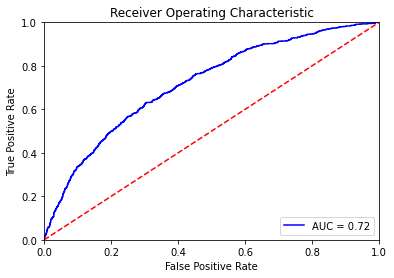

In [67]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [68]:
data.shape

(388241, 53)

In [69]:
high = data.loc[data['SEGM']=='01.HIGH']
medium = data.loc[data['SEGM']=='02.MEDIUM']
low = data.loc[data['SEGM']=='03.LOW']
norb = data.loc[data['SEGM']=='04.NORB']

In [70]:
scaler = MinMaxScaler()
high[process_column_names] = scaler.fit_transform(high[process_column_names])
high.groupby('app_flag').mean()

<ipython-input-70-4ff02a5563dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high[process_column_names] = scaler.fit_transform(high[process_column_names])
/home/yliu40/anaconda32/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,PRIMARY_USER_ID,USER_CNTRY_ID,BYNG_TRANS_CNT_365D,GMB_USD_AMT_365D,ITEM_PRCHSD_CNT_365D,BID_CNT_365D,OFFER_CNT_365D,ADD_TO_CART_CNT_365D,WATCH_CNT_365D,CNT_TOTAL_ITEMS_365D,...,ITEM_PRCHSD_CNT_07D,BID_CNT_07D,OFFER_CNT_07D,ADD_TO_CART_CNT_07D,WATCH_CNT_07D,CNT_TOTAL_ITEMS_07D,CNT_VERTICALS_07D,CNT_META_CATEG_07D,CNT_CNDTN_ROLLUP_07D,POST_GMB_USD_AMT_365D
app_flag,,,,,,,,,,,,,,,,,,,,,
0,5.802016e+08,77.0,0.271665,0.305283,0.311997,0.235967,0.220986,0.443713,0.332894,0.329169,...,0.235276,0.202499,0.055554,0.167733,0.186691,0.259600,0.256625,0.214171,0.405827,4352.356655
1,6.875380e+08,77.0,0.214846,0.257448,0.254283,0.178745,0.198516,0.414158,0.312863,0.266885,...,0.198641,0.169191,0.043790,0.150945,0.163422,0.226349,0.238068,0.192697,0.374508,2625.481327


In [71]:
scaler = MinMaxScaler()
medium[process_column_names] = scaler.fit_transform(medium[process_column_names])
medium.groupby('app_flag').mean()

<ipython-input-71-ea355fceb844>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medium[process_column_names] = scaler.fit_transform(medium[process_column_names])
/home/yliu40/anaconda32/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,PRIMARY_USER_ID,USER_CNTRY_ID,BYNG_TRANS_CNT_365D,GMB_USD_AMT_365D,ITEM_PRCHSD_CNT_365D,BID_CNT_365D,OFFER_CNT_365D,ADD_TO_CART_CNT_365D,WATCH_CNT_365D,CNT_TOTAL_ITEMS_365D,...,ITEM_PRCHSD_CNT_07D,BID_CNT_07D,OFFER_CNT_07D,ADD_TO_CART_CNT_07D,WATCH_CNT_07D,CNT_TOTAL_ITEMS_07D,CNT_VERTICALS_07D,CNT_META_CATEG_07D,CNT_CNDTN_ROLLUP_07D,POST_GMB_USD_AMT_365D
app_flag,,,,,,,,,,,,,,,,,,,,,
0,6.038363e+08,77.0,0.421127,0.568435,0.438422,0.330084,0.157003,0.363593,0.268905,0.401406,...,0.188504,0.156611,0.037213,0.143452,0.177658,0.212665,0.209168,0.171889,0.352545,968.295193
1,8.790743e+08,77.0,0.324941,0.503636,0.339410,0.240670,0.104141,0.290547,0.203854,0.292695,...,0.129504,0.110477,0.028804,0.114221,0.138372,0.160605,0.144628,0.118764,0.282318,611.213183


In [72]:
scaler = MinMaxScaler()
low[process_column_names] = scaler.fit_transform(low[process_column_names])
low.groupby('app_flag').mean()

<ipython-input-72-7039497ecc27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low[process_column_names] = scaler.fit_transform(low[process_column_names])
/home/yliu40/anaconda32/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,PRIMARY_USER_ID,USER_CNTRY_ID,BYNG_TRANS_CNT_365D,GMB_USD_AMT_365D,ITEM_PRCHSD_CNT_365D,BID_CNT_365D,OFFER_CNT_365D,ADD_TO_CART_CNT_365D,WATCH_CNT_365D,CNT_TOTAL_ITEMS_365D,...,ITEM_PRCHSD_CNT_07D,BID_CNT_07D,OFFER_CNT_07D,ADD_TO_CART_CNT_07D,WATCH_CNT_07D,CNT_TOTAL_ITEMS_07D,CNT_VERTICALS_07D,CNT_META_CATEG_07D,CNT_CNDTN_ROLLUP_07D,POST_GMB_USD_AMT_365D
app_flag,,,,,,,,,,,,,,,,,,,,,
0,8.598042e+08,77.0,0.243957,0.417874,0.235582,0.222856,0.051903,0.161046,0.159024,0.239774,...,0.081844,0.124785,0.028473,0.110300,0.112144,0.153203,0.055138,0.054697,0.176721,212.932843
1,1.233563e+09,77.0,0.229709,0.407524,0.212928,0.210760,0.040716,0.182534,0.152166,0.216048,...,0.056915,0.116374,0.026130,0.135725,0.135006,0.160998,0.076578,0.076902,0.171934,232.564406


In [73]:
scaler = MinMaxScaler()
norb[process_column_names] = scaler.fit_transform(norb[process_column_names])
norb.groupby('app_flag').mean()

<ipython-input-73-b7381584287d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norb[process_column_names] = scaler.fit_transform(norb[process_column_names])
/home/yliu40/anaconda32/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,PRIMARY_USER_ID,USER_CNTRY_ID,BYNG_TRANS_CNT_365D,GMB_USD_AMT_365D,ITEM_PRCHSD_CNT_365D,BID_CNT_365D,OFFER_CNT_365D,ADD_TO_CART_CNT_365D,WATCH_CNT_365D,CNT_TOTAL_ITEMS_365D,...,ITEM_PRCHSD_CNT_07D,BID_CNT_07D,OFFER_CNT_07D,ADD_TO_CART_CNT_07D,WATCH_CNT_07D,CNT_TOTAL_ITEMS_07D,CNT_VERTICALS_07D,CNT_META_CATEG_07D,CNT_CNDTN_ROLLUP_07D,POST_GMB_USD_AMT_365D
app_flag,,,,,,,,,,,,,,,,,,,,,
0,1.438958e+09,77.0,0.167095,0.363554,0.184639,0.258265,0.053392,0.247605,0.16669,0.302669,...,0.177736,0.185131,0.028802,0.160429,0.117361,0.204550,0.123342,0.095609,0.305602,950.422366
1,1.749267e+09,77.0,0.077277,0.304151,0.088597,0.175810,0.022475,0.193002,0.09955,0.206861,...,0.126191,0.137014,0.014525,0.146613,0.081511,0.154039,0.085265,0.063777,0.242846,387.385318


In [74]:
data_new = high.append([medium, low, norb])
data_new.shape

(388241, 53)

In [75]:
pscore = best_model.predict_proba(data_new[process_column_names])[:,1]

In [76]:
pscore[163:246]

array([0.03533431, 0.71014681, 0.11794682, 0.4298048 , 0.54957532,
       0.6453422 , 0.5811192 , 0.63649059, 0.30315712, 0.76938133,
       0.81096114, 0.4922883 , 0.35603164, 0.68451213, 0.12897154,
       0.57743803, 0.4683519 , 0.56254909, 0.39905252, 0.79636703,
       0.70816012, 0.29756883, 0.38911705, 0.64480134, 0.28168774,
       0.62364715, 0.34217552, 0.6130047 , 0.50114495, 0.2117355 ,
       0.72332162, 0.38411662, 0.5514459 , 0.37058916, 0.7604147 ,
       0.55725021, 0.3135255 , 0.08208725, 0.78159893, 0.1158367 ,
       0.3076486 , 0.10344838, 0.30936379, 0.51103494, 0.6206445 ,
       0.51286509, 0.47256298, 0.3429855 , 0.53506066, 0.7640528 ,
       0.7519141 , 0.03496527, 0.21237522, 0.66838782, 0.56946265,
       0.73158674, 0.31841486, 0.57867986, 0.70832985, 0.19222592,
       0.53412117, 0.74638717, 0.7050083 , 0.52188439, 0.56018603,
       0.69442651, 0.34274238, 0.75564063, 0.67290862, 0.53056847,
       0.90490761, 0.20205376, 0.59084411, 0.40517684, 0.41751

In [77]:
data_new['Propensity'] = pscore

In [78]:
#data.to_csv('US_Propensity_Sample.csv')

## Matching (Capping data)

In [79]:
#dir = '/home/hanlchen/App_CLV/'
#input_file_name = 'US_Propensity_Sample.csv'

In [80]:
df=data_new

In [81]:
#df = pd.read_csv(dir + input_file_name, delimiter=',')

In [82]:
#dir = '/home/hanlchen/App_CLV/'
#capping_input_file_name ="US_CAPPING_CLV_Data.csv"

In [83]:
#capping_data = pd.read_csv(dir + capping_input_file_name, delimiter=',')
sql_str = """select PRIMARY_USER_ID, SEGM, TXN_DT, GMB_CAP from P_TRAFFIC_T.HC_DE_USER_FM_2001_V3_1000"""  
capping_data = pd.read_sql(sql_str, conn)

In [84]:
capping_data.head(5)

,PRIMARY_USER_ID,SEGM,TXN_DT,GMB_CAP
0,9.700433e+07,02.MEDIUM,2020-04-11,1713.776550
1,5.645890e+08,02.MEDIUM,2020-05-24,426.738137
2,8.469396e+08,02.MEDIUM,2020-04-03,1945.339365
3,5.265891e+08,02.MEDIUM,2020-06-23,890.349709
4,1.834112e+09,02.MEDIUM,2020-04-21,7.874588


In [85]:
print(capping_data.groupby('SEGM')['GMB_CAP'].count())
print(capping_data.groupby('SEGM')['GMB_CAP'].mean())
print(capping_data.groupby('SEGM')['GMB_CAP'].std())

SEGM
01.HIGH       73834
02.MEDIUM    292250
03.LOW         5498
04.NORB       16659
Name: GMB_CAP, dtype: int64
SEGM
01.HIGH      3893.655616
02.MEDIUM     960.104689
03.LOW        195.437012
04.NORB       764.025415
Name: GMB_CAP, dtype: float64
SEGM
01.HIGH      4300.116232
02.MEDIUM    1251.268442
03.LOW        686.994102
04.NORB      2188.170625
Name: GMB_CAP, dtype: float64


In [86]:
df= pd.merge(df,capping_data, on=["PRIMARY_USER_ID","SEGM","TXN_DT"], how="left")

In [87]:
df.shape

(388241, 55)

In [88]:
df.head()

,PRIMARY_USER_ID,USER_CNTRY_ID,TXN_DT,USER_GROUP,SEGM,USR_CREATED_DT,OPT_IN_EMAIL_IND,BYNG_TRANS_CNT_365D,GMB_USD_AMT_365D,ITEM_PRCHSD_CNT_365D,...,ADD_TO_CART_CNT_07D,WATCH_CNT_07D,CNT_TOTAL_ITEMS_07D,CNT_VERTICALS_07D,CNT_META_CATEG_07D,CNT_CNDTN_ROLLUP_07D,app_flag,POST_GMB_USD_AMT_365D,Propensity,GMB_CAP
0,7.955908e+08,77.0,2020-04-28,0,01.HIGH,2008-07-02,Y,0.342526,0.472568,0.354670,...,0.366199,0.828956,0.700568,0.237845,0.259203,0.731416,0,7330.680546,0.234924,7330.680546
1,1.388729e+08,77.0,2020-05-19,0,01.HIGH,2004-06-09,N,0.363825,0.287184,0.364505,...,0.231046,0.593320,0.470166,0.000000,0.000000,0.323657,0,8410.529742,0.324898,8410.529742
2,1.045655e+09,77.0,2020-05-01,0,01.HIGH,2011-01-28,Y,0.161623,0.259635,0.167186,...,0.154031,0.339391,0.298702,0.406598,0.259203,0.731416,0,1307.687917,0.543768,1307.687917
3,1.674118e+09,77.0,2020-04-08,0,01.HIGH,2017-09-18,Y,0.187484,0.217766,0.189829,...,0.077015,0.000000,0.052599,0.000000,0.000000,0.000000,0,4076.397448,0.456624,4076.397448
4,1.078545e+09,77.0,2020-06-11,0,01.HIGH,2011-09-15,Y,0.397104,0.342850,0.397104,...,0.244133,0.286819,0.285034,0.000000,0.000000,0.553295,0,6723.934269,0.336639,6723.934269


In [89]:
column_names_V3 =['GMB_CAP','PRIMARY_USER_ID','SEGM','TXN_DT','USER_GROUP','app_flag','Propensity']
#,"GMB_USD_AMT_365D"

In [90]:
data_matching = df[column_names_V3]

In [91]:
data_matching.head()

,GMB_CAP,PRIMARY_USER_ID,SEGM,TXN_DT,USER_GROUP,app_flag,Propensity
0,7330.680546,7.955908e+08,01.HIGH,2020-04-28,0,0,0.234924
1,8410.529742,1.388729e+08,01.HIGH,2020-05-19,0,0,0.324898
2,1307.687917,1.045655e+09,01.HIGH,2020-05-01,0,0,0.543768
3,4076.397448,1.674118e+09,01.HIGH,2020-04-08,0,0,0.456624
4,6723.934269,1.078545e+09,01.HIGH,2020-06-11,0,0,0.336639


In [92]:
#data_matching['TXN_DT'] = pd.to_datetime(data_matching['TXN_DT'])

In [93]:
data_matching_t = data_matching.loc[data_matching['app_flag']==1]
data_matching_t.shape

(3844, 7)

In [94]:
data_matching_c = data_matching.loc[data_matching['app_flag']==0]
data_matching_c.shape

(384397, 7)

In [95]:
data_matching_sorted_c = data_matching_c.sort_values(by='Propensity', ascending=False)
#data_matching_sorted_c
data_matching_sorted_t = data_matching_t.sort_values(by='Propensity', ascending=False)
#data_matching_sorted_t

In [96]:
SEGM_match= data_matching_sorted_t.drop_duplicates('SEGM')['SEGM']

In [97]:
SEGM_match

382698      04.NORB
369061       03.LOW
216398    02.MEDIUM
42920       01.HIGH
Name: SEGM, dtype: object

In [98]:
TXN_DT_match=data_matching_sorted_t.drop_duplicates('TXN_DT')['TXN_DT']
TXN_DT_match

382698    2020-06-29
369061    2020-06-26
370966    2020-06-18
370314    2020-06-21
381330    2020-06-28
             ...    
366526    2020-05-31
147930    2020-04-05
238708    2020-05-30
177620    2020-05-27
191281    2020-05-19
Name: TXN_DT, Length: 91, dtype: object

In [99]:
SEGM_match=SEGM_match.tolist()
TXN_DT_match=TXN_DT_match.tolist()

In [100]:
data_matching_sorted_c_final= pd.DataFrame()

for i in SEGM_match:
    for j in TXN_DT_match:
        print(i,j)
        data_matching_sorted_t_temp = data_matching_sorted_t.loc[ (data_matching_sorted_t['SEGM']==i) & (data_matching_sorted_t['TXN_DT']==j) ] 
        data_matching_sorted_c_temp = data_matching_sorted_c.loc[ (data_matching_sorted_c['SEGM']==i) & (data_matching_sorted_c['TXN_DT']==j) ]

        count = 0
        index_list = []
        start_point = 0 
        loc = 0  # keep track of searching position
        
        
        for index_t, row_t in data_matching_sorted_t_temp.iterrows():
            target = row_t['Propensity']
            #print("target ",target)

            data_matching_sorted_c_temp['target'] = target
            data_matching_sorted_c_temp['diff'] = abs(data_matching_sorted_c_temp['target'] - data_matching_sorted_c_temp['Propensity'])
            index_c=data_matching_sorted_c_temp['diff'].idxmin()
            #print(index_c)
            #print( data_matching_sorted_c_temp.loc[ data_matching_sorted_c_temp['diff'].idxmin()])
            #print("min diff",data_matching_sorted_c_temp['diff'].min())
            
            if data_matching_sorted_c_temp['diff'].min() > 0.1 : 
                pass
            else: 
                index_list.append(index_c)

        data_matching_sorted_c_temp=data_matching_sorted_c_temp.loc[index_list]
        data_matching_sorted_c_final=data_matching_sorted_c_final.append(data_matching_sorted_c_temp)
        data_matching_sorted_c=data_matching_sorted_c[~data_matching_sorted_c.PRIMARY_USER_ID.isin(data_matching_sorted_c_final.PRIMARY_USER_ID)]
         
         

04.NORB 2020-06-29


<ipython-input-100-fcd5982f0fd9>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_matching_sorted_c_temp['target'] = target
<ipython-input-100-fcd5982f0fd9>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_matching_sorted_c_temp['diff'] = abs(data_matching_sorted_c_temp['target'] - data_matching_sorted_c_temp['Propensity'])


04.NORB 2020-06-26
04.NORB 2020-06-18
04.NORB 2020-06-21
04.NORB 2020-06-28
04.NORB 2020-06-07
04.NORB 2020-05-13
04.NORB 2020-06-10
04.NORB 2020-04-19
04.NORB 2020-06-27
04.NORB 2020-04-20
04.NORB 2020-04-04
04.NORB 2020-06-17
04.NORB 2020-06-12
04.NORB 2020-06-16
04.NORB 2020-06-24
04.NORB 2020-06-03
04.NORB 2020-05-04
04.NORB 2020-06-09
04.NORB 2020-04-17
04.NORB 2020-06-22
04.NORB 2020-06-25
04.NORB 2020-05-08
04.NORB 2020-04-06
04.NORB 2020-06-11
04.NORB 2020-06-05
04.NORB 2020-05-05
04.NORB 2020-04-15
04.NORB 2020-05-20
04.NORB 2020-05-28
04.NORB 2020-06-14
04.NORB 2020-04-16
04.NORB 2020-06-20
04.NORB 2020-05-29
04.NORB 2020-06-06
04.NORB 2020-04-30
04.NORB 2020-05-15
04.NORB 2020-04-26
04.NORB 2020-05-06
04.NORB 2020-04-22
04.NORB 2020-06-23
04.NORB 2020-06-08
04.NORB 2020-04-27
04.NORB 2020-06-15
04.NORB 2020-04-09
04.NORB 2020-04-10
04.NORB 2020-04-07
04.NORB 2020-05-03
04.NORB 2020-06-19
04.NORB 2020-05-17
04.NORB 2020-04-24
04.NORB 2020-05-12
04.NORB 2020-06-04
04.NORB 2020

In [101]:
data_matching_sorted_c_final.shape

(3835, 9)

In [102]:
data_matching_sorted_t.groupby('SEGM')['GMB_CAP'].mean()

SEGM
01.HIGH      2596.408673
02.MEDIUM     600.359199
03.LOW        232.564406
04.NORB       385.441182
Name: GMB_CAP, dtype: float64

## CLVi

In [103]:
data_matching_sorted_t.groupby('SEGM')['GMB_CAP'].mean()-data_matching_sorted_c_final.groupby('SEGM')['GMB_CAP'].mean()

SEGM
01.HIGH     -306.787145
02.MEDIUM    -11.498910
03.LOW       -23.355888
04.NORB        7.019340
Name: GMB_CAP, dtype: float64

In [104]:
data_matching_sorted_t.groupby('SEGM')['PRIMARY_USER_ID'].count()

SEGM
01.HIGH       205
02.MEDIUM    2383
03.LOW        290
04.NORB       966
Name: PRIMARY_USER_ID, dtype: int64

In [105]:
#data_matching_sorted_t.groupby('SEGM')['GMB_USD_AMT_365D'].mean()-data_matching_sorted_c_final.groupby('SEGM')['GMB_USD_AMT_365D'].mean()

## publiser 

In [106]:
data_matching_c = data_matching.loc[data_matching['USER_GROUP']=="0"]
data_matching_c.shape

(384397, 7)

In [107]:
data_matching_t_uac = data_matching.loc[data_matching['USER_GROUP']=="1"]
data_matching_t_uac.shape

(2683, 7)

In [108]:
data_matching_t_fb = data_matching.loc[data_matching['USER_GROUP']=="2"]
data_matching_t_fb.shape

(1161, 7)

In [109]:
data_matching_sorted_c = data_matching_c.sort_values(by='Propensity', ascending=False)

In [110]:
data_matching_t_uac = data_matching_t_uac.sort_values(by='Propensity', ascending=False)
data_matching_t_fb = data_matching_t_fb.sort_values(by='Propensity', ascending=False)

In [111]:
SEGM_match_uac= data_matching_t_uac.drop_duplicates('SEGM')['SEGM']
TXN_DT_match_uac=data_matching_t_uac.drop_duplicates('TXN_DT')['TXN_DT']

In [112]:
SEGM_match=SEGM_match_uac.tolist()
TXN_DT_match=TXN_DT_match_uac.tolist()

In [113]:
data_matching_sorted_c_uac_final= pd.DataFrame()

for i in SEGM_match:
    for j in TXN_DT_match:
        print(i,j)
        data_matching_sorted_t_temp = data_matching_t_uac.loc[ (data_matching_t_uac['SEGM']==i) & (data_matching_t_uac['TXN_DT']==j) ] 
        data_matching_sorted_c_temp = data_matching_sorted_c.loc[ (data_matching_sorted_c['SEGM']==i) & (data_matching_sorted_c['TXN_DT']==j) ]

        count = 0
        index_list = []
        start_point = 0 
        loc = 0  # keep track of searching position
        
        
        for index_t, row_t in data_matching_sorted_t_temp.iterrows():
            target = row_t['Propensity']
            #print("target ",target)

            data_matching_sorted_c_temp['target'] = target
            data_matching_sorted_c_temp['diff'] = abs(data_matching_sorted_c_temp['target'] - data_matching_sorted_c_temp['Propensity'])
            index_c=data_matching_sorted_c_temp['diff'].idxmin()
            #print(index_c)
            #print( data_matching_sorted_c_temp.loc[ data_matching_sorted_c_temp['diff'].idxmin()])
            #print("min diff",data_matching_sorted_c_temp['diff'].min())
            
            if data_matching_sorted_c_temp['diff'].min() > 0.1 : 
                pass
            else: 
                index_list.append(index_c)
                
        data_matching_sorted_c_temp=data_matching_sorted_c_temp.loc[index_list]
        data_matching_sorted_c_uac_final=data_matching_sorted_c_uac_final.append(data_matching_sorted_c_temp)
        data_matching_sorted_c=data_matching_sorted_c[~data_matching_sorted_c.PRIMARY_USER_ID.isin(data_matching_sorted_c_uac_final.PRIMARY_USER_ID)]

04.NORB 2020-06-29


<ipython-input-113-19ef9df03bec>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_matching_sorted_c_temp['target'] = target
<ipython-input-113-19ef9df03bec>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_matching_sorted_c_temp['diff'] = abs(data_matching_sorted_c_temp['target'] - data_matching_sorted_c_temp['Propensity'])


04.NORB 2020-06-26
04.NORB 2020-06-18
04.NORB 2020-06-21
04.NORB 2020-06-28
04.NORB 2020-06-07
04.NORB 2020-06-10
04.NORB 2020-06-27
04.NORB 2020-06-17
04.NORB 2020-06-12
04.NORB 2020-04-20
04.NORB 2020-06-16
04.NORB 2020-06-24
04.NORB 2020-06-09
04.NORB 2020-04-17
04.NORB 2020-06-22
04.NORB 2020-06-25
04.NORB 2020-04-06
04.NORB 2020-06-05
04.NORB 2020-04-15
04.NORB 2020-05-20
04.NORB 2020-05-28
04.NORB 2020-06-14
04.NORB 2020-04-16
04.NORB 2020-04-30
04.NORB 2020-04-19
04.NORB 2020-05-15
04.NORB 2020-04-26
04.NORB 2020-06-06
04.NORB 2020-06-23
04.NORB 2020-04-27
04.NORB 2020-06-15
04.NORB 2020-06-08
04.NORB 2020-04-09
04.NORB 2020-04-10
04.NORB 2020-05-03
04.NORB 2020-06-11
04.NORB 2020-06-19
04.NORB 2020-04-24
04.NORB 2020-06-03
04.NORB 2020-05-12
04.NORB 2020-04-07
04.NORB 2020-06-04
04.NORB 2020-04-12
04.NORB 2020-05-14
04.NORB 2020-04-21
04.NORB 2020-06-13
04.NORB 2020-05-13
04.NORB 2020-06-30
04.NORB 2020-04-13
04.NORB 2020-04-08
04.NORB 2020-04-25
04.NORB 2020-04-28
04.NORB 2020

In [114]:
data_matching_sorted_c_uac_final.shape

(2678, 9)

In [115]:
data_matching_sorted_c_uac_final.groupby('SEGM')['GMB_CAP'].mean()

SEGM
01.HIGH      3033.334421
02.MEDIUM     657.132714
03.LOW        263.062367
04.NORB       385.818077
Name: GMB_CAP, dtype: float64

In [116]:
data_matching_t_uac.groupby('SEGM')['GMB_CAP'].mean()

SEGM
01.HIGH      2550.026963
02.MEDIUM     652.422592
03.LOW        240.951588
04.NORB       417.581719
Name: GMB_CAP, dtype: float64

## Google CLVi

In [117]:
data_matching_t_uac.groupby('SEGM')['GMB_CAP'].mean()-data_matching_sorted_c_uac_final.groupby('SEGM')['GMB_CAP'].mean()

SEGM
01.HIGH     -483.307457
02.MEDIUM     -4.710122
03.LOW       -22.110779
04.NORB       31.763642
Name: GMB_CAP, dtype: float64

In [118]:
data_matching_t_uac.groupby('SEGM')['PRIMARY_USER_ID'].count()

SEGM
01.HIGH       167
02.MEDIUM    1737
03.LOW        194
04.NORB       585
Name: PRIMARY_USER_ID, dtype: int64

In [119]:
data_matching_sorted_c.shape

(380873, 7)

In [120]:
SEGM_match_fb= data_matching_t_fb.drop_duplicates('SEGM')['SEGM']
TXN_DT_match_fb=data_matching_t_fb.drop_duplicates('TXN_DT')['TXN_DT']

In [121]:
SEGM_match=SEGM_match_fb.tolist()
TXN_DT_match=TXN_DT_match_fb.tolist()

In [122]:
data_matching_sorted_c_fb_final= pd.DataFrame()

for i in SEGM_match:
    for j in TXN_DT_match:
        print(i,j)
        data_matching_sorted_t_temp = data_matching_t_fb.loc[ (data_matching_t_fb['SEGM']==i) & (data_matching_t_fb['TXN_DT']==j) ] 
        data_matching_sorted_c_temp = data_matching_sorted_c.loc[ (data_matching_sorted_c['SEGM']==i) & (data_matching_sorted_c['TXN_DT']==j) ]

        count = 0
        index_list = []
        start_point = 0 
        loc = 0  # keep track of searching position
        
        
        for index_t, row_t in data_matching_sorted_t_temp.iterrows():
            target = row_t['Propensity']
            #print("target ",target)

            data_matching_sorted_c_temp['target'] = target
            data_matching_sorted_c_temp['diff'] = abs(data_matching_sorted_c_temp['target'] - data_matching_sorted_c_temp['Propensity'])
            index_c=data_matching_sorted_c_temp['diff'].idxmin()
            #print(index_c)
            #print( data_matching_sorted_c_temp.loc[ data_matching_sorted_c_temp['diff'].idxmin()])
            #print("min diff",data_matching_sorted_c_temp['diff'].min())
            
            if data_matching_sorted_c_temp['diff'].min() > 0.1 : 
                pass
            else: 
                index_list.append(index_c)
                
        data_matching_sorted_c_temp=data_matching_sorted_c_temp.loc[index_list]
        data_matching_sorted_c_fb_final=data_matching_sorted_c_fb_final.append(data_matching_sorted_c_temp)
        data_matching_sorted_c=data_matching_sorted_c[~data_matching_sorted_c.PRIMARY_USER_ID.isin(data_matching_sorted_c_fb_final.PRIMARY_USER_ID)]

02.MEDIUM 2020-05-13


<ipython-input-122-be8e83999e02>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_matching_sorted_c_temp['target'] = target
<ipython-input-122-be8e83999e02>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_matching_sorted_c_temp['diff'] = abs(data_matching_sorted_c_temp['target'] - data_matching_sorted_c_temp['Propensity'])


02.MEDIUM 2020-04-19
02.MEDIUM 2020-04-20
02.MEDIUM 2020-06-26
02.MEDIUM 2020-04-04
02.MEDIUM 2020-06-03
02.MEDIUM 2020-05-04
02.MEDIUM 2020-05-08
02.MEDIUM 2020-06-11
02.MEDIUM 2020-05-05
02.MEDIUM 2020-06-20
02.MEDIUM 2020-05-29
02.MEDIUM 2020-06-21
02.MEDIUM 2020-06-06
02.MEDIUM 2020-05-06
02.MEDIUM 2020-05-15
02.MEDIUM 2020-04-22
02.MEDIUM 2020-06-12
02.MEDIUM 2020-06-08
02.MEDIUM 2020-06-07
02.MEDIUM 2020-06-16
02.MEDIUM 2020-06-15
02.MEDIUM 2020-04-07
02.MEDIUM 2020-05-17
02.MEDIUM 2020-06-09
02.MEDIUM 2020-06-24
02.MEDIUM 2020-06-22
02.MEDIUM 2020-06-14
02.MEDIUM 2020-05-14
02.MEDIUM 2020-06-01
02.MEDIUM 2020-06-02
02.MEDIUM 2020-04-26
02.MEDIUM 2020-04-11
02.MEDIUM 2020-05-01
02.MEDIUM 2020-04-18
02.MEDIUM 2020-04-06
02.MEDIUM 2020-05-02
02.MEDIUM 2020-05-22
02.MEDIUM 2020-06-29
02.MEDIUM 2020-04-17
02.MEDIUM 2020-05-09
02.MEDIUM 2020-05-07
02.MEDIUM 2020-04-21
02.MEDIUM 2020-06-19
02.MEDIUM 2020-04-03
02.MEDIUM 2020-04-13
02.MEDIUM 2020-05-12
02.MEDIUM 2020-04-15
02.MEDIUM 202

In [123]:
data_matching_sorted_c_fb_final.shape

(1157, 9)

In [124]:
data_matching_sorted_c_fb_final.groupby('SEGM')['GMB_CAP'].mean()

SEGM
01.HIGH      2265.322407
02.MEDIUM     496.337537
03.LOW        238.157869
04.NORB       280.267927
Name: GMB_CAP, dtype: float64

In [125]:
data_matching_t_fb.groupby('SEGM')['GMB_CAP'].mean()

SEGM
01.HIGH      2800.244082
02.MEDIUM     460.368310
03.LOW        215.615308
04.NORB       336.091539
Name: GMB_CAP, dtype: float64

## FB CLVi

In [126]:
data_matching_t_fb.groupby('SEGM')['GMB_CAP'].mean()-data_matching_sorted_c_fb_final.groupby('SEGM')['GMB_CAP'].mean()

SEGM
01.HIGH      534.921675
02.MEDIUM    -35.969226
03.LOW       -22.542561
04.NORB       55.823612
Name: GMB_CAP, dtype: float64

In [127]:
data_matching_t_fb.groupby('SEGM')['PRIMARY_USER_ID'].count()

SEGM
01.HIGH       38
02.MEDIUM    646
03.LOW        96
04.NORB      381
Name: PRIMARY_USER_ID, dtype: int64